In [1]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer

import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



import shap

In [2]:
# path to the dataset
file_path = "Dry_Eye_Dataset.csv"

# Load the latest version of the file
df0 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dakshnagra/dry-eye-disease",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_95113/3521891120.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df0 = kagglehub.load_dataset(


In [7]:
df = df0.copy()

#Make everything lower case, and replace space with '_'
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Split the blood_pressure column into two new columns
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True)

# Define the Blood Pressure Category
def categorize_bp(row):
    if 110 <= int(row['systolic']) <= 120 and 70 <= int(row['diastolic']) <= 80:
        return 'normal'
    elif int(row['systolic']) > 120 or int(row['diastolic']) > 80:
        return 'high'
    else:
        return 'low'
# New BP category column
df['bp_category'] = df.apply(categorize_bp, axis=1)
print('Types of variables in bp_category:',df['bp_category'].nunique())

#Drop Blood pressure colums including systolic and diastolic
#df = df.drop(columns=['blood_pressure', 'systolic', 'diastolic'])

# Identify categorical columns
#categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#omit_cols = ['blood_pressure', 'systolic', 'diastolic']
#omit_cols = ['blood_pressure', 'systolic', 'diastolic', 'medical_issue', 'stress_level', 'ongoing_medication', 'age', 'smart_device_before_bed', 'blue-light_filter', 'daily_steps', 'sleep_quality', 'smoking']
# omit_cols = ['medical_issue',\
#     'stress_level', 'ongoing_medication', 'age', 'smart_device_before_bed',\
#         'blue-light_filter', 'daily_steps', 'sleep_quality', 'smoking',\
#             'sleep_duration', 'feel_sleepy_during_day', 'heart_rate', 'height']
#df = df.drop(columns=omit_cols)

Types of variables in bp_category: 3
Classes for column gender: ['F' 'M']
Classes for column sleep_disorder: ['N' 'Y']
Classes for column wake_up_during_night: ['N' 'Y']
Classes for column feel_sleepy_during_day: ['N' 'Y']
Classes for column caffeine_consumption: ['N' 'Y']
Classes for column alcohol_consumption: ['N' 'Y']
Classes for column smoking: ['N' 'Y']
Classes for column medical_issue: ['N' 'Y']
Classes for column ongoing_medication: ['N' 'Y']
Classes for column smart_device_before_bed: ['N' 'Y']
Classes for column blue-light_filter: ['N' 'Y']
Classes for column discomfort_eye-strain: ['N' 'Y']
Classes for column redness_in_eye: ['N' 'Y']
Classes for column itchiness/irritation_in_eye: ['N' 'Y']
Classes for column dry_eye_disease: ['N' 'Y']
Classes for column bp_category: ['high' 'low' 'normal']
['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'blood_pressure', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_du

In [8]:
def detect_outliers_iqr(df):
    outlier_info = {}
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        percent_outliers = 100 * len(outliers) / len(df)
        outlier_info[col] = {
            "num_outliers": len(outliers),
            "percent_outliers": round(percent_outliers, 2),
        }
    return pd.DataFrame(outlier_info).T

# Get outlier stats
outlier_stats = detect_outliers_iqr(df)
print(outlier_stats)

                             num_outliers  percent_outliers
gender                                0.0               0.0
age                                   0.0               0.0
sleep_duration                        0.0               0.0
sleep_quality                         0.0               0.0
stress_level                          0.0               0.0
heart_rate                            0.0               0.0
daily_steps                           0.0               0.0
physical_activity                     0.0               0.0
height                                0.0               0.0
weight                                0.0               0.0
sleep_disorder                        0.0               0.0
wake_up_during_night                  0.0               0.0
feel_sleepy_during_day                0.0               0.0
caffeine_consumption                  0.0               0.0
alcohol_consumption                   0.0               0.0
smoking                               0.

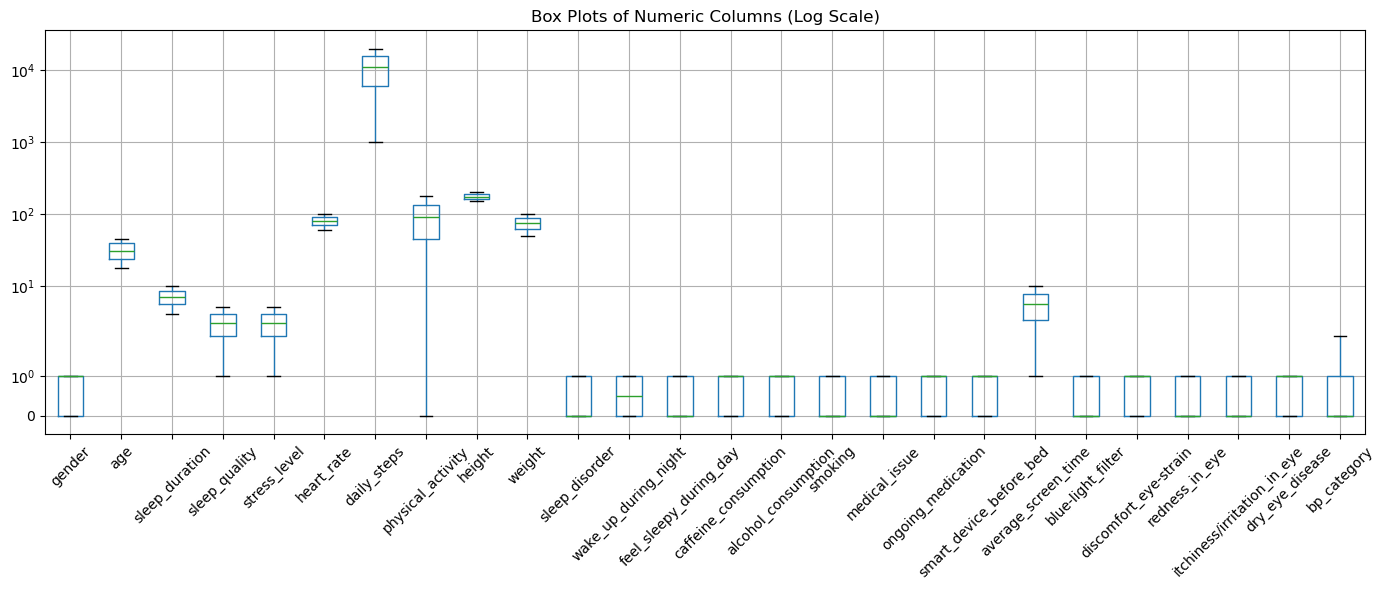

In [16]:
plt.figure(figsize=(14, 6))
df.select_dtypes(include=[np.number]).boxplot()
plt.yscale('symlog')
plt.title("Box Plots of Numeric Columns (Log Scale)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()